In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, top_k_accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier

from src.data_loader import *
from src.visualization import *

%load_ext autoreload
%autoreload 1
%aimport src.data_loader
%aimport src.visualization

In [2]:
df = pd.read_csv("./data/dataset.csv")

In [3]:
df.head()

,item_id,faces,edges,vertices,file_name,depth,width,height,area,volume,...,bbox_area,bbox_volume,quantity,technology_id,material_id,post_processing_id,download_file_url,technology_name,material_name,Is_CNC
0,100033,3792.0,11286.0,7524.0,100033_Design_8.step,154.600000,66.000000,154.600000,259187.574998,854521.623711,...,154.600000,1.577477e+06,1,3cbbeb15-b617-431e-84b4-d2d8fa144cf3,100,[127],https://prod-mv-user-files-upload.s3.eu-centra...,FDM,Other material (manual request),0
1,100034,568.0,1479.0,956.0,100034_5_77_v2.STEP,563.089004,98.888454,518.719571,796131.889763,912613.085344,...,518.719571,2.888386e+07,1,bed1f100-32c8-42b2-9735-1e36286c7823,13,[74],https://prod-mv-user-files-upload.s3.eu-centra...,MJF,PA12,0
2,100035,216.0,637.0,423.0,100035_MakerVerse_Sample.step,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,163.662476,4.971657e+06,1,feb0f26f-94a5-4be2-9d40-761bb2857ab6,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),Aluminum 6082 (3.2315),1
3,100036,216.0,637.0,423.0,100036_MakerVerse_Sample.step,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,163.662476,4.971657e+06,1,feb0f26f-94a5-4be2-9d40-761bb2857ab6,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),Aluminum 6082 (3.2315),1
4,100040,216.0,637.0,423.0,100040_00048125_Stator_Pump.step,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,163.662476,4.971657e+06,1,feb0f26f-94a5-4be2-9d40-761bb2857ab6,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),Aluminum 6082 (3.2315),1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64863 entries, 0 to 64862
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   item_id             64863 non-null  int64  
 1   faces               64863 non-null  float64
 2   edges               64863 non-null  float64
 3   vertices            64863 non-null  float64
 4   file_name           64863 non-null  object 
 5   depth               64863 non-null  float64
 6   width               64863 non-null  float64
 7   height              64863 non-null  float64
 8   area                64863 non-null  float64
 9   volume              64863 non-null  float64
 10  bbox_depth          64863 non-null  float64
 11  bbox_height         64863 non-null  float64
 12  bbox_width          64863 non-null  float64
 13  bbox_area           64863 non-null  float64
 14  bbox_volume         64863 non-null  float64
 15  quantity            64863 non-null  int64  
 16  tech

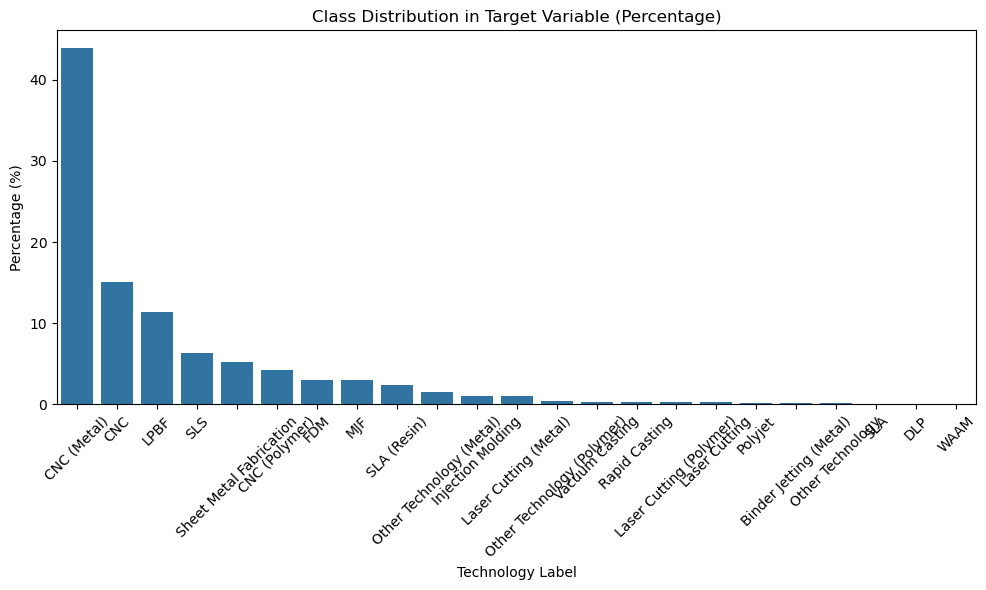

technology_name
CNC (Metal)                   43.91 %
CNC                           15.07 %
LPBF                          11.41 %
SLS                            6.29 %
Sheet Metal Fabrication        5.21 %
CNC (Polymer)                  4.26 %
FDM                            3.04 %
MJF                            2.97 %
SLA (Resin)                    2.42 %
Other Technology (Metal)       1.53 %
Injection Molding              1.02 %
Laser Cutting (Metal)          0.98 %
Other Technology (Polymer)     0.34 %
Vacuum Casting                 0.31 %
Rapid Casting                   0.3 %
Laser Cutting (Polymer)        0.26 %
Laser Cutting                  0.23 %
Polyjet                        0.11 %
Binder Jetting (Metal)         0.11 %
Other Technology               0.09 %
SLA                            0.07 %
DLP                            0.04 %
WAAM                           0.02 %
Name: proportion, dtype: object


In [6]:
# Count the number of samples per class
label_counts = df['technology_name'].value_counts(normalize=True).sort_values(ascending=False) * 100

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.ylabel("Percentage (%)")
plt.xlabel("Technology Label")
plt.title("Class Distribution in Target Variable (Percentage)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print exact percentages
print(label_counts.round(2).astype(str) + " %")


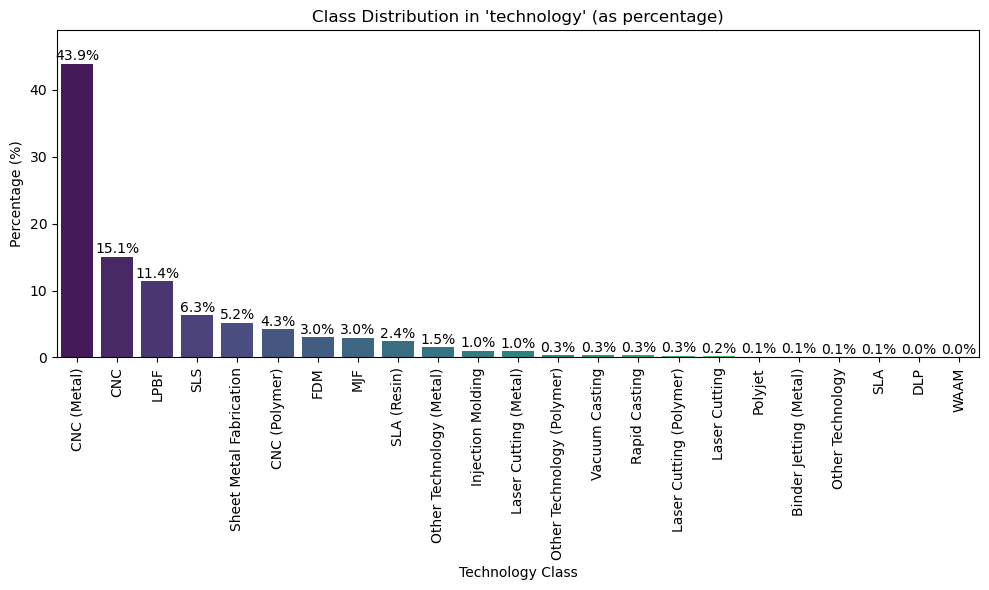

In [8]:
# Percentage of each class
class_percentages = df['technology_name'].value_counts(normalize=True).sort_index().sort_values(ascending=False) * 100

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_percentages.index, y=class_percentages.values, hue=class_percentages.index, palette="viridis", legend=False)

plt.title("Class Distribution in 'technology' (as percentage)")
plt.ylabel("Percentage (%)")
plt.xlabel("Technology Class")
plt.xticks(rotation=90)
plt.ylim(0, class_percentages.max() + 5)

# Annotate bars with percentage values
for index, value in enumerate(class_percentages.values):
    plt.text(index, value + 0.5, f"{value:.1f}%", ha='center')

plt.tight_layout()
plt.show()


In [11]:
# For the baseline model ,we will drop classes below a threshold of 1%
classes_to_keep = class_percentages[class_percentages >= 1].index.tolist()

# Filter the DataFrame to keep only the selected classes
df_filtered = df[df['technology_name'].isin(classes_to_keep)].reset_index(drop=True)
df_filtered.technology_name.value_counts()

technology_name
CNC (Metal)                 28482
CNC                          9777
LPBF                         7398
SLS                          4077
Sheet Metal Fabrication      3382
CNC (Polymer)                2760
FDM                          1973
MJF                          1929
SLA (Resin)                  1571
Other Technology (Metal)      995
Injection Molding             662
Name: count, dtype: int64

In [13]:
# Encode the labels
le = LabelEncoder()
df_filtered['label'] = le.fit_transform(df_filtered['technology_name'])
# Save the encoder
joblib.dump(le, "./models/label_encoder.pkl")

['./models/label_encoder.pkl']

In [14]:
df_filtered.head()

,item_id,faces,edges,vertices,file_name,depth,width,height,area,volume,...,bbox_volume,quantity,technology_id,material_id,post_processing_id,download_file_url,technology_name,material_name,Is_CNC,label
0,100033,3792.0,11286.0,7524.0,100033_Design_8.step,154.600000,66.000000,154.600000,259187.574998,854521.623711,...,1.577477e+06,1,3cbbeb15-b617-431e-84b4-d2d8fa144cf3,100,[127],https://prod-mv-user-files-upload.s3.eu-centra...,FDM,Other material (manual request),0,3
1,100034,568.0,1479.0,956.0,100034_5_77_v2.STEP,563.089004,98.888454,518.719571,796131.889763,912613.085344,...,2.888386e+07,1,bed1f100-32c8-42b2-9735-1e36286c7823,13,[74],https://prod-mv-user-files-upload.s3.eu-centra...,MJF,PA12,0,6
2,100035,216.0,637.0,423.0,100035_MakerVerse_Sample.step,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,4.971657e+06,1,feb0f26f-94a5-4be2-9d40-761bb2857ab6,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),Aluminum 6082 (3.2315),1,1
3,100036,216.0,637.0,423.0,100036_MakerVerse_Sample.step,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,4.971657e+06,1,feb0f26f-94a5-4be2-9d40-761bb2857ab6,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),Aluminum 6082 (3.2315),1,1
4,100040,216.0,637.0,423.0,100040_00048125_Stator_Pump.step,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,4.971657e+06,1,feb0f26f-94a5-4be2-9d40-761bb2857ab6,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),Aluminum 6082 (3.2315),1,1


In [11]:
features = ["area", "width", "height", "depth", "volume"]
X = df_filtered[features]
y = df_filtered['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Train XGBoost model
model_baseline = XGBClassifier(
    objective="multi:softprof",
    num_class=len(df_filtered['label'].unique()),
    random_state=42,
    eval_metric="mlogloss",
    n_estimators=100,
)
model_baseline.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=11, ...)

In [12]:
y_pred = model_baseline.predict(X_test)
y_prob = model_baseline.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
top3 = top_k_accuracy_score(y_test, y_prob, k=3)

print("🔹 Baseline Model (No Sample Weights)")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score (Macro): {f1:.4f}")
print(f"Top-3 Accuracy: {top3:.4f}")

🔹 Baseline Model (No Sample Weights)
Accuracy: 0.7026
F1 Score (Macro): 0.4925
Top-3 Accuracy: 0.8978


In [14]:
# Calculate accury for each class
per_class_results = []

for label in np.unique(y_test):
    class_name = le.inverse_transform([label])[0]
    mask = y_test == label
    total = np.sum(mask)
    correct = np.sum(y_pred[mask] == y_test[mask])
    acc = correct / total

    per_class_results.append({
        "Label ID": label,
        "Class": class_name,
        "Accuracy": round(acc, 4),
        "Samples": total
    })

df_per_class = pd.DataFrame(per_class_results).sort_values(by="Accuracy", ascending=False)
df_per_class.reset_index(drop=True, inplace=True)

df_per_class

,Label ID,Class,Accuracy,Samples
0,0,CNC,0.9412,6988
1,10,Sheet Metal Fabrication,0.5604,646
2,4,LPBF,0.4500,1491
3,5,Laser Cutting,0.4103,195
4,7,Other Technology,0.3915,258
5,1,CNC (Polymer),0.3823,586
6,8,SLA (Resin),0.3344,299
7,9,SLS,0.3161,889
8,6,MJF,0.2650,400
9,2,FDM,0.2273,374


In [15]:
print(classification_report(y_test, y_pred, target_names=le.classes_))

                         precision    recall  f1-score   support

                    CNC       0.73      0.94      0.82      6988
          CNC (Polymer)       0.84      0.38      0.53       586
                    FDM       0.71      0.23      0.34       374
      Injection Molding       0.64      0.20      0.31       135
                   LPBF       0.50      0.45      0.47      1491
          Laser Cutting       0.72      0.41      0.52       195
                    MJF       0.73      0.27      0.39       400
       Other Technology       0.75      0.39      0.52       258
            SLA (Resin)       0.76      0.33      0.46       299
                    SLS       0.71      0.32      0.44       889
Sheet Metal Fabrication       0.70      0.56      0.62       646

               accuracy                           0.70     12261
              macro avg       0.71      0.41      0.49     12261
           weighted avg       0.70      0.70      0.67     12261



In [16]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train  # numeric class labels
)
model_weighted = XGBClassifier(
    objective='multi:softprob',
    num_class=len(df_filtered['label'].unique()),
    eval_metric='mlogloss',
    random_state=42
)

model_weighted.fit(X_train, y_train, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=11, ...)

In [17]:
y_pred_weighted = model_weighted.predict(X_test)
y_prob_weighted = model_weighted.predict_proba(X_test)

acc_w = accuracy_score(y_test, y_pred_weighted)
f1_w = f1_score(y_test, y_pred_weighted, average='macro')
top3_w = top_k_accuracy_score(y_test, y_prob_weighted, k=3)

print("🔸 Weighted Model (Sample Weights Applied)")
print(f"Accuracy: {acc_w:.4f}")
print(f"F1 Score (Macro): {f1_w:.4f}")
print(f"Top-3 Accuracy: {top3_w:.4f}")

🔸 Weighted Model (Sample Weights Applied)
Accuracy: 0.5567
F1 Score (Macro): 0.4477
Top-3 Accuracy: 0.8148


In [19]:
# Calculate accury for each class
per_class_results_weighted = []

for label in np.unique(y_test):
    class_name = le.inverse_transform([label])[0]
    mask = y_test == label
    total = np.sum(mask)
    correct = np.sum(y_pred_weighted[mask] == y_test[mask])
    acc = correct / total

    per_class_results_weighted.append({
        "Label ID": label,
        "Class": class_name,
        "Accuracy": round(acc, 4),
        "Samples": total
    })

df_per_class_weighted = pd.DataFrame(per_class_results_weighted).sort_values(by="Accuracy", ascending=False)
df_per_class_weighted.reset_index(drop=True, inplace=True)

df_per_class_weighted

,Label ID,Class,Accuracy,Samples
0,10,Sheet Metal Fabrication,0.6997,646
1,1,CNC (Polymer),0.6911,586
2,5,Laser Cutting,0.6718,195
3,7,Other Technology,0.6395,258
4,6,MJF,0.5825,400
5,9,SLS,0.5726,889
6,0,CNC,0.5663,6988
7,3,Injection Molding,0.5111,135
8,8,SLA (Resin),0.4950,299
9,2,FDM,0.4706,374


In [20]:
print(classification_report(y_test, y_pred_weighted, target_names=le.classes_))

                         precision    recall  f1-score   support

                    CNC       0.88      0.57      0.69      6988
          CNC (Polymer)       0.37      0.69      0.48       586
                    FDM       0.27      0.47      0.35       374
      Injection Molding       0.17      0.51      0.26       135
                   LPBF       0.47      0.39      0.43      1491
          Laser Cutting       0.34      0.67      0.45       195
                    MJF       0.24      0.58      0.34       400
       Other Technology       0.33      0.64      0.44       258
            SLA (Resin)       0.39      0.49      0.43       299
                    SLS       0.40      0.57      0.47       889
Sheet Metal Fabrication       0.50      0.70      0.59       646

               accuracy                           0.56     12261
              macro avg       0.40      0.57      0.45     12261
           weighted avg       0.67      0.56      0.58     12261



In [21]:
df_summary = df_per_class + df_per_class_weighted
df_summary

,Label ID,Class,Accuracy,Samples
0,10,CNCSheet Metal Fabrication,1.6409,7634
1,11,Sheet Metal FabricationCNC (Polymer),1.2515,1232
2,9,LPBFLaser Cutting,1.1218,1686
3,12,Laser CuttingOther Technology,1.0498,453
4,13,Other TechnologyMJF,0.9740,658
5,10,CNC (Polymer)SLS,0.9549,1475
6,8,SLA (Resin)CNC,0.9007,7287
7,12,SLSInjection Molding,0.8272,1024
8,14,MJFSLA (Resin),0.7600,699
9,4,FDMFDM,0.6979,748


In [22]:
df_per_class.columns

Index(['Label ID', 'Class', 'Accuracy', 'Samples'], dtype='object')

In [23]:
df_per_class.rename(columns={"Accuracy": "Unweighted Accuracy"}, inplace=True)
df_per_class_weighted.rename(columns={"Accuracy": "Weighted Accuracy"}, inplace=True)
df_summary = pd.merge(
    df_per_class,
    df_per_class_weighted[["Label ID", "Weighted Accuracy"]],
    on="Label ID",
    how="inner"
)
df_summary = df_summary[['Label ID', 'Class', 'Unweighted Accuracy', 'Weighted Accuracy', 'Samples']]
df_summary

,Label ID,Class,Unweighted Accuracy,Weighted Accuracy,Samples
0,0,CNC,0.9412,0.5663,6988
1,10,Sheet Metal Fabrication,0.5604,0.6997,646
2,4,LPBF,0.4500,0.3897,1491
3,5,Laser Cutting,0.4103,0.6718,195
4,7,Other Technology,0.3915,0.6395,258
5,1,CNC (Polymer),0.3823,0.6911,586
6,8,SLA (Resin),0.3344,0.4950,299
7,9,SLS,0.3161,0.5726,889
8,6,MJF,0.2650,0.5825,400
9,2,FDM,0.2273,0.4706,374


In [24]:
df_summary.columns

Index(['Label ID', 'Class', 'Unweighted Accuracy', 'Weighted Accuracy',
       'Samples'],
      dtype='object')

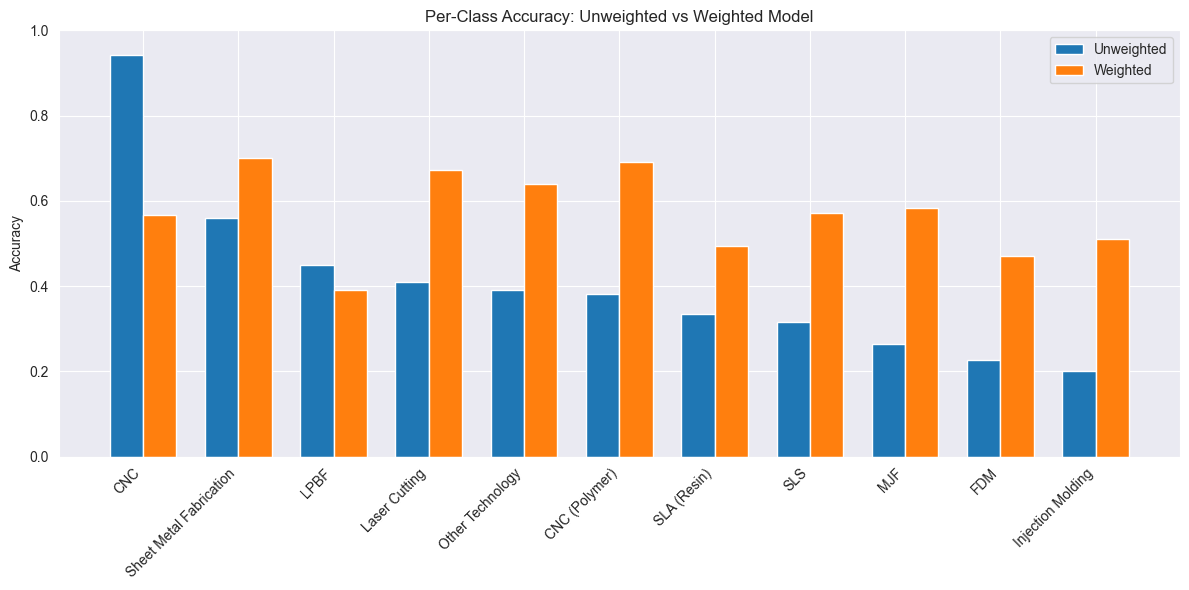

In [25]:
# Bar plots of both weighted and unweighted accuracy values
labels = df_summary['Class']
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, df_summary['Unweighted Accuracy'], width, label='Unweighted')
plt.bar(x + width/2, df_summary['Weighted Accuracy'], width, label='Weighted')

plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy: Unweighted vs Weighted Model")
plt.xticks(ticks=x, labels=labels, rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


## Intial Observations and Conclusion
- The weighted model significantly boosts accuracy for most of the minority classes (FDM, CNC (Polymer), (MJF) and Injection Molding).
- Trade-off is the reduced accuracy of the majority clas+s (CNC and LPBF), which is expected.
- The weighted model generalizes better and more robust.